# Analysis notebook

## Imports

In [50]:
from locpix.preprocessing import datastruc
import os
import polars as pl
from locpix.visualise import vis_img
import numpy as np


## Load in membrane segmentation

In [28]:
method = 'ilastik'
fold = 0

In [37]:
# folders
input_folder = f"../../../../../../output/c15_cells/membrane_performance/{method}/membrane/seg_dataframes/test/{fold}"

# load in first item
files = os.listdir(input_folder)
file = files[0]

# load item
item_memb = datastruc.item(None, None, None, None, None)
item_memb.load_from_parquet(os.path.join(input_folder, file))


In [38]:
# rename label to membrane 
item_memb.df = item_memb.df.rename({'pred_label':'memb_label'})
print(item_memb.df.head(2))

shape: (2, 7)
┌─────────┬────────┬─────────────┬────────────┬──────────┬──────┬────────────┐
│ channel ┆ frame  ┆ x           ┆ y          ┆ gt_label ┆ prob ┆ memb_label │
│ ---     ┆ ---    ┆ ---         ┆ ---        ┆ ---      ┆ ---  ┆ ---        │
│ f32     ┆ f32    ┆ f32         ┆ f32        ┆ f64      ┆ f64  ┆ i64        │
╞═════════╪════════╪═════════════╪════════════╪══════════╪══════╪════════════╡
│ 1.0     ┆ 3520.0 ┆ 4380.027832 ┆ 428.297882 ┆ 0.0      ┆ 0.15 ┆ 0          │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 1.0     ┆ 3520.0 ┆ 6990.032715 ┆ 650.009949 ┆ 0.0      ┆ 0.19 ┆ 0          │
└─────────┴────────┴─────────────┴────────────┴──────────┴──────┴────────────┘


## Load in cell segmentation

In [39]:
# load in cell seg
if method == "ilastik":
    file = f"../../../../../../output/c15_cells/{method}/output/cell/dataframe/{fold}/{file}"
else:
    file = f"../../../../../../output/c15_cells/{method}/cell/seg_dataframes/{file}"

# load cell item
item_cell = datastruc.item(None, None, None, None, None)
item_cell.load_from_parquet(file)

In [40]:
# rename label to cell membrane
item_cell.df = item_cell.df.rename({'pred_label':'cell_label'})
print(item_cell.df.head(2))

shape: (2, 6)
┌─────────┬────────┬─────────────┬────────────┬──────────┬────────────┐
│ channel ┆ frame  ┆ x           ┆ y          ┆ gt_label ┆ cell_label │
│ ---     ┆ ---    ┆ ---         ┆ ---        ┆ ---      ┆ ---        │
│ f32     ┆ f32    ┆ f32         ┆ f32        ┆ f64      ┆ f64        │
╞═════════╪════════╪═════════════╪════════════╪══════════╪════════════╡
│ 1.0     ┆ 3520.0 ┆ 4380.027832 ┆ 428.297882 ┆ 0.0      ┆ 1.0        │
├╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 1.0     ┆ 3520.0 ┆ 6990.032715 ┆ 650.009949 ┆ 0.0      ┆ 1.0        │
└─────────┴────────┴─────────────┴────────────┴──────────┴────────────┘


## Identify cells at the membrane

In [61]:
# final df

final_df = item_memb.df.join(item_cell.df, how='inner', on=['channel','frame','x','y','gt_label'])
final_df = final_df.filter(pl.col("memb_label") == 1)

# see difference 
print(f"{round(100.0*(len(final_df)/len(item_cell.df)), 1)}%")

20.1%


## Load final df into fresh loaded in item so can use the metadata

In [62]:
agg = datastruc.item(None, None, None, None, None)
agg.load_from_parquet(file)
agg.df = final_df
agg._coord_2_pixel()

In [63]:
channel = "egfr"
threshold = 0
interpolation = 'log2'
alphas = [1,.5,.2,.1]
alpha_seg = 0.8
cmap_seg = ["k", "y"]
figsize = [10,10]
four_colour = False
background_one_colour = False
legend=False
column_vis="pred_label"

## want to plot localisations for each cell in sequence!

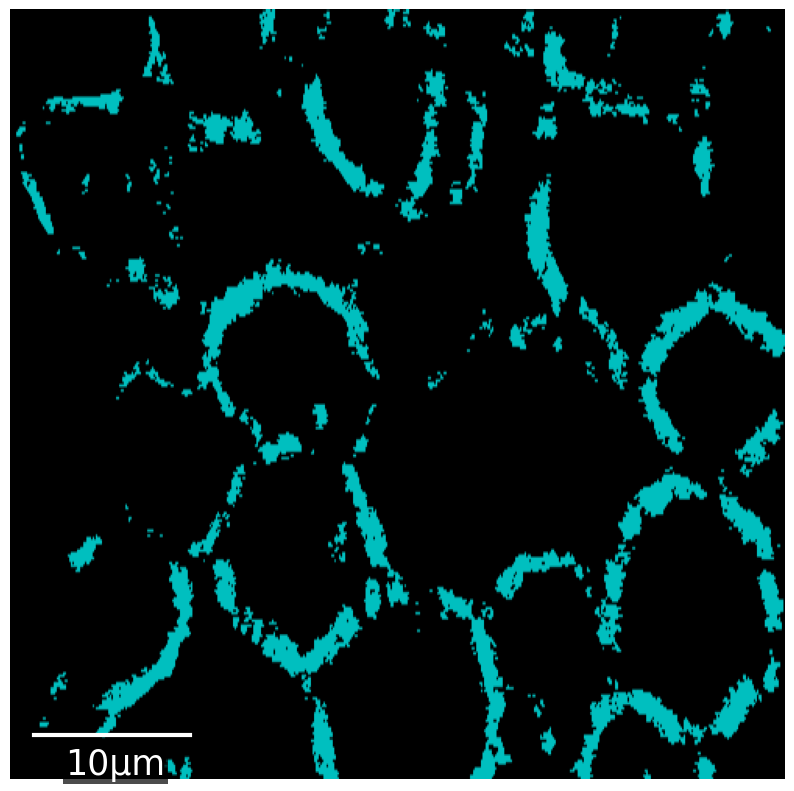

In [91]:
# render histogram & convert to img one cell at a time
agg.df = final_df
agg._coord_2_pixel()
#agg.df = agg.df.filter(pl.col("cell_label")==2.0)

#def fooo():
#    histo, channel_map, label_map = agg.render_histo()

#def foo():
labels = agg.df.select(pl.col("cell_label")).to_numpy()
x_pixels = agg.df.select(pl.col("x_pixel")).to_numpy()
y_pixels = agg.df.select(pl.col("y_pixel")).to_numpy()
histo_width = np.max(x_pixels) + 1
histo_height = np.max(y_pixels) + 1
histo = np.zeros((histo_width, histo_height), dtype=np.int64)
histo[x_pixels, y_pixels] = labels
histo = np.expand_dims(histo, axis=0)  

#fooo()   

img = np.transpose(histo, (0, 2, 1))

# render segmentation
# item.histo_mask = render.visualise_seg_item(item, column_vis)

# only visualise one channel
vis_img.visualise_seg(
    img,
    np.zeros((500,500)),# item.histo_mask.T,
    agg.bin_sizes, 
    axes=[0],
    label_map=label_map,
    threshold=threshold,
    how=interpolation,
    alphas=alphas,
    blend_overlays=False,
    alpha_seg=alpha_seg,
    cmap_img=None,
    cmap_seg=cmap_seg,
    figsize=figsize,
    origin="upper",
    save=False,
    save_loc=None,
    four_colour=four_colour,
    background_one_colour=background_one_colour,
    legend=legend,
    show=True,
)